In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import preprocessing
from tqdm import tqdm
import weka.core.jvm as jvm
from weka.core.converters import Loader
from weka.classifiers import Classifier
from weka.classifiers import Evaluation
from weka.core.classes import Random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from sklearn import datasets
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.ensemble import BaggingClassifier
import warnings

In [11]:
warnings.filterwarnings('ignore')

In [4]:
jvm.start()
loader = Loader(classname="weka.core.converters.ArffLoader")
data = loader.load_file("human_activity.arff")
data.class_is_last()
cls = Classifier(classname="weka.classifiers.functions.SMO")
evl = Evaluation(data)
evl.crossvalidate_model(cls, data, 10, Random(1))

print(evl.percent_correct)
print(evl.summary())
print(evl.class_details())

98.50470919506748

Correctly Classified Instances       10145               98.5047 %
Incorrectly Classified Instances       154                1.4953 %
Kappa statistic                          0.982 
Mean absolute error                      0.2226
Root mean squared error                  0.3107
Relative absolute error                 80.3187 %
Root relative squared error             83.4718 %
Total Number of Instances            10299     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.960    0.009    0.961      0.960    0.960      0.951    0.991     0.944     STANDING
                 0.958    0.009    0.957      0.958    0.957      0.948    0.986     0.930     SITTING
                 1.000    0.000    1.000      1.000    1.000      1.000    1.000     1.000     LAYING
                 1.000    0.000    0.999      1.000    0.999      0.999    1.000     0.999     WALKING
     

In [2]:
df = pd.read_csv("human_activity.csv").drop('Unnamed: 0',1)

In [3]:
x = df.drop("label", 1).values
encoder = LabelEncoder()
y = encoder.fit_transform(df["label"])

The bellow cells are commented out as they should not be run again

In [45]:
# X_train, X_final_test, y_train, y_final_test = train_test_split(x, y, test_size=0.1)

In [83]:
# xtrain_df,ytrain_df = pd.DataFrame(X_train),pd.DataFrame(y_train,columns=["label"])
# train = pd.concat([xtrain_df,ytrain_df],axis=1)
# train.to_csv("Final_training.csv")

In [ ]:
# xtrain_df,ytrain_df = pd.DataFrame(X_train),pd.DataFrame(y_train,columns=["label"])
# train = pd.concat([xtrain_df,ytrain_df],axis=1)
# train.to_csv("Final_training.csv")

In [84]:
# x_test_df,y_test_df = pd.DataFrame(X_final_test),pd.DataFrame(y_final_test,columns=["label"])
# test = pd.concat([x_test_df,y_test_df],axis=1)
# test.to_csv("Final_test.csv")

In [2]:
train_df = pd.read_csv("Final_training.csv").drop('Unnamed: 0',1)

In [3]:
X_train = train_df.drop("label", 1).values
y_train = train_df["label"].values

In [9]:
def k_fold_test(x,y,classifier,n_splits=10):
    kf = KFold(n_splits=n_splits)
    total_accuracy = 0
    for train_index, test_index in kf.split(x):
        y_train, y_test = y[train_index], y[test_index]
        x_train, x_test = x[train_index], x[test_index]
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        accuracy = accuracy_score(y_pred, y_test)
        total_accuracy += accuracy
    return total_accuracy/n_splits

In [51]:
classifiers = [
        MLPClassifier(alpha=1),
        LogisticRegression(),
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        AdaBoostClassifier(),
        GaussianNB(),
        CatBoostClassifier(iterations=500, learning_rate=0.3, depth=5, loss_function='MultiClass', classes_count=6, logging_level='Silent', l2_leaf_reg=2, thread_count=4),
        RandomForestClassifier(n_estimators=70, max_depth=5, max_features=0.8, n_jobs=4, class_weight='balanced'),
        BernoulliNB(),
    ]
names = [
    "MLP",
    "logistic regression",
    "KNN",
    "SVC",
    "AdaBoostClassifier",
    "GaussianNB",
    "CatBoostClassifier",
    "RandomForestClassifier",
    "BernoulliNB"
]
for name,classifier in zip(names,classifiers):
    accuracy = k_fold_test(X_train,y_train,classifier,n_splits=4) 
    print(name+ " :")
    print(accuracy)
    
    

MLP :
0.972812320906769
logistic regression :
0.9824145109691171
KNN :
0.9658001052356016
SVC :
0.9747546271453484
AdaBoostClassifier :
0.5420203690097911
GaussianNB :
0.7630759237998914
CatBoostClassifier :
0.9903979495814967
RandomForestClassifier :
0.9205955307266731
BernoulliNB :
0.8473395333959186


In [10]:
def svc_param_selection(X, y,kernel, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_

Paremeter optimizing svc among different kernels

In [ ]:
best_params = svc_param_selection(X_train,y_train,'poly',10)

In [102]:
best_params

{'C': 0.001, 'gamma': 1}

In [103]:
poly_accuracy = k_fold_test(X_train,y_train,SVC(kernel="poly",C=.001,gamma=1))
poly_accuracy

0.9911535620839654

In [ ]:
linear_best_params = svc_param_selection(X_train,y_train,'linear',10)

In [105]:
linear_best_params

{'C': 10, 'gamma': 0.001}

In [10]:
linear_accuracy = k_fold_test(X_train,y_train,SVC(kernel="linear",C=10,gamma=.001))
linear_accuracy

0.9873777088124213

Paremeter optimizing neural network

In [13]:
parameter_space_neural_net = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.1,1],
    'learning_rate': ['constant','adaptive'],
}

In [14]:
mlp = MLPClassifier(max_iter=100)
mlp_random = RandomizedSearchCV(estimator = mlp, param_distributions = parameter_space_neural_net, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1)
mlp_random.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 31.7min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'solver': ['sgd', 'adam'], 'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)], 'learning_rate': ['constant', 'adaptive'], 'activation': ['tanh', 'relu'], 'alpha': [0.0001, 0.1, 1]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [15]:
mlp_random.best_params_

{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate': 'constant',
 'solver': 'sgd'}

In [22]:
mlp_accuracy = k_fold_test(X_train,y_train,MLPClassifier(activation='tanh',alpha=.0001,hidden_layer_sizes=(50, 50, 50),learning_rate='constant',solver='sgd'))
mlp_accuracy

0.9818759741939092

Paremeter optimizing random forest

In [16]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [17]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid_rf, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 55.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 110.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'min_samples_split': [2, 5, 10], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [33]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}

In [28]:
random_forest = RandomForestClassifier(bootstrap=False,max_depth=40,max_features='auto',min_samples_leaf=1,min_samples_split=2,n_estimators=1400)
random_forest_accuracy = k_fold_test(random_forest)

0.9395106003566476


Paremeter optimizing catboost

In [31]:
cat_boost_params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[500],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'thread_count':[6]}

In [32]:
cb = CatBoostClassifier()
cb_random = RandomizedSearchCV(estimator = cb, param_distributions = cat_boost_params, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1)
cb_random.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [ ]:
cb_random.best_params_

In [35]:
final_classifiers = [
MLPClassifier(activation='tanh',alpha=.0001,hidden_layer_sizes=(50, 50, 50),learning_rate='constant',solver='sgd'),
SVC(kernel="poly",C=.001,gamma=1,probability=True),
RandomForestClassifier(bootstrap=False,max_depth=40,max_features='auto',min_samples_leaf=1,min_samples_split=2,n_estimators=1400),
LogisticRegression(),
KNeighborsClassifier(3),
CatBoostClassifier(iterations=500,learning_rate=.03,depth=5, loss_function='MultiClass', logging_level='Silent', l2_leaf_reg=2, thread_count=8)
]
final_names = ["svc","random forest","logistic regression", "KNN", "Catboost"]

In [40]:
def get_level_data(X,y,classifiers):
    print("Starting meta learning")
    num_labels = len(set(y))
    kf = KFold(n_splits=10)
    level1 = np.zeros((X.shape[0], len(classifiers)*num_labels))
    split_index = 0
    for tr_idx, te_idx in kf.split(X):
        split_index+=1
        print("Split index {}".format(split_index))
        X_tr, y_tr = X[tr_idx], y[tr_idx]
        X_te, y_te = X[te_idx], y[te_idx]
        for clf_index,clf in enumerate(classifiers):
#             print("Clf index {}".format(clf_index))
            clf.fit(X_tr,y_tr)
            predictions = clf.predict_proba(X_te)
            for label_index in range(num_labels):
                current = clf_index*num_labels+label_index
                level1[te_idx,current] = predictions[:,label_index]
    return level1

In [ ]:
level1_train = get_level_data(X_train,y_train,final_classifiers)

Starting meta learning
Split index 1


In [4]:
def get_level1_test(X_train,y_train,X_test,classifiers):
    num_labels = len(set(y_train))
    kf = KFold(n_splits=10)
    level1 = np.zeros((X_test.shape[0], len(classifiers)*num_labels))
    split_index = 0
    for clf_index,clf in enumerate(classifiers):
        clf.fit(X_train,y_train)
        predictions = clf.predict_proba(X_test)
        for label_index in range(num_labels):
            current = clf_index*num_labels+label_index
            level1[:,current] = predictions[:,label_index]
    return level1

In [42]:
level1_test = get_level1_test(X_train,y_train,X_test,final_classifiers)

In [3]:
def test_meta_classifier(level1_train,y_train,level1_test,y_test):
    meta_clf = RidgeClassifier(normalize=True, class_weight='balanced')
    meta_clf.fit(level1_train, y_train)
    meta_preds = meta_clf.predict(level1_test)
    accuracy = accuracy_score(meta_preds, y_test)
    return accuracy

In [43]:
test_meta_classifier(level1_train,y_train,level1_test,y_test)

0.9922330097087378

Found only 3 unique classes but defined 6 classes probably something is wrong with data.


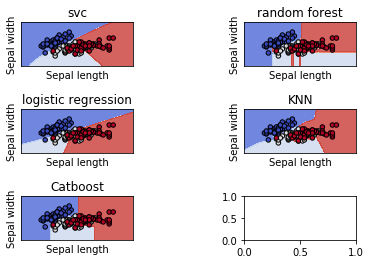

In [27]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X_iris = iris.data[:, :2]
encoder = LabelEncoder()
y_iris = encoder.fit_transform(iris.target)
fitted_classifiers = [clf.fit(X_iris, y_iris) for clf in final_classifiers]
# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(3, 2)
plt.subplots_adjust(wspace=1, hspace=1)

X0, X1 = X_iris[:, 0], X_iris[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(fitted_classifiers, final_names, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_iris, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()

In [34]:
meta_train = get_level_data(X_iris,y_iris,final_classifiers)
meta_clf = RidgeClassifier(normalize=True, class_weight='balanced')
meta_clf.fit(meta_train,y_iris)
test_data = get_level1_test(X_iris, y_iris,np.c_[xx.ravel(), yy.ravel()],final_classifiers)
meta_z = meta_clf.predict(test_data)
meta_z = meta_z.reshape(xx.shape)

Starting meta learning


TODO fix colors

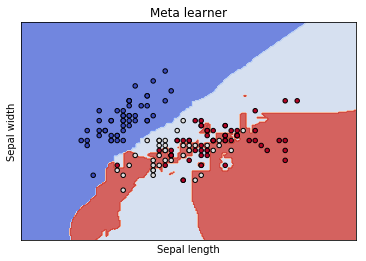

In [50]:
ax = plt.axes()
out = ax.contourf(xx, yy, meta_z,cmap=plt.cm.coolwarm, alpha=0.8)

plt.scatter(X0, X1, c=y_iris, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title("Meta learner")
plt.show()

In [ ]:
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
X, _ = load_digits(return_X_y=True)
X.shape
(1797, 64)
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(X[:100])
X_transformed.shape
(100, 2)

In [20]:
def test_meta_model(names,classifiers,x,y,n_splits =10):
    kf = KFold(n_splits=n_splits)
    model_to_accuracy = defaultdict(list)
    split_index = 0
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    for train_index, test_index in kf.split(x):
        split_index+=1
        y_train, y_test = y[train_index], y[test_index]
        x_train, x_test = x[train_index], x[test_index]
        for name,classifier in zip(names,classifiers):
            classifier.fit(x_train, y_train)
            y_pred = classifier.predict(x_test)
            model_to_accuracy[name].append(accuracy_score(y_pred, y_test))
        level1_train = get_level_data(x_train,y_train,classifiers)
        level1_test = get_level1_test(x_train,y_train,x_test,classifiers)
        meta_accuracy = test_meta_classifier(level1_train,y_train,level1_test,y_test)
        print(meta_accuracy)
        model_to_accuracy["meta_learner"].append(meta_accuracy)
    return model_to_accuracy

In [6]:
def test_accuracies(model_to_accuracy,p=.05):
    meta_learner_accuracies = model_to_accuracy["meta_learner"]
    for model in model_to_accuracy:
        if model!="meta_learner":
            p_score = stats.ttest_rel(meta_learner_accuracies,model_to_accuracy[model])[1]
            if p_score<.05:
                print("There is a significant difference between the meta learner and model {}".format(model))
            else:
                print("There is no significant difference between the meta learner and model {}".format(model))

In [36]:
iris = datasets.load_iris()
iris_accuracies = test_meta_model(final_names,final_classifiers,iris.data,iris.target,n_splits=10)
iris_accuracies

Starting meta learning
1.0
Starting meta learning
1.0
Starting meta learning
1.0
Starting meta learning
1.0
Starting meta learning
0.8666666666666667
Starting meta learning
0.8666666666666667
Starting meta learning
1.0
Starting meta learning
0.8666666666666667
Starting meta learning
0.8666666666666667
Starting meta learning
1.0


defaultdict(list,
            {'Catboost': [1.0,
              1.0,
              1.0,
              1.0,
              0.9333333333333333,
              0.8666666666666667,
              1.0,
              0.8666666666666667,
              0.8,
              0.9333333333333333],
             'KNN': [1.0,
              1.0,
              1.0,
              1.0,
              0.8666666666666667,
              0.8666666666666667,
              1.0,
              0.8666666666666667,
              0.8666666666666667,
              1.0],
             'logistic regression': [1.0,
              1.0,
              1.0,
              0.8666666666666667,
              0.7333333333333333,
              0.6666666666666666,
              1.0,
              0.9333333333333333,
              0.6,
              1.0],
             'meta_learner': [1.0,
              1.0,
              1.0,
              1.0,
              0.8666666666666667,
              0.8666666666666667,
              1.0,
        

In [37]:
test_accuracies(iris_accuracies)

There is no significant difference between the meta learner and model KNN
There is no significant difference between the meta learner and model svc
There is no significant difference between the meta learner and model random forest
There is no significant difference between the meta learner and model Catboost
There is no significant difference between the meta learner and model logistic regression


In [38]:
digits = datasets.load_digits() 

In [39]:
digits_accuracies = test_meta_model(final_names,final_classifiers,digits.data,digits.target)
digits_accuracies

Starting meta learning
0.95
Starting meta learning
1.0
Starting meta learning
0.9444444444444444
Starting meta learning
0.9888888888888889
Starting meta learning
0.9722222222222222
Starting meta learning
0.9888888888888889
Starting meta learning
0.9944444444444445
Starting meta learning
0.994413407821229
Starting meta learning
0.9608938547486033
Starting meta learning
0.9608938547486033


defaultdict(list,
            {'Catboost': [0.9055555555555556,
              0.9833333333333333,
              0.9222222222222223,
              0.9722222222222222,
              0.9555555555555556,
              0.9833333333333333,
              0.9777777777777777,
              0.9497206703910615,
              0.9217877094972067,
              0.9329608938547486],
             'KNN': [0.9388888888888889,
              1.0,
              0.9888888888888889,
              0.9833333333333333,
              0.9555555555555556,
              0.9833333333333333,
              0.9833333333333333,
              0.9888268156424581,
              0.9832402234636871,
              0.9664804469273743],
             'logistic regression': [0.9055555555555556,
              0.95,
              0.8944444444444445,
              0.9166666666666666,
              0.9444444444444444,
              0.9722222222222222,
              0.9777777777777777,
              0.9553072625698324,
              0

In [44]:
test_accuracies(digits_accuracies)

There is no significant difference between the meta learner and model KNN
There is no significant difference between the meta learner and model svc
There is a significant difference between the meta learner and model random forest
There is a significant difference between the meta learner and model Catboost
There is a significant difference between the meta learner and model logistic regression


In [21]:
human_activity_accuracies = test_meta_model(final_names,final_classifiers,x,y,n_splits=10)

Starting meta learning
0.974757281553398
Starting meta learning
0.962135922330097
Starting meta learning
0.9844660194174757
Starting meta learning
0.970873786407767
Starting meta learning
0.9533980582524272
Starting meta learning
0.9029126213592233
Starting meta learning
0.9553398058252427
Starting meta learning
0.987378640776699
Starting meta learning


KeyboardInterrupt: 

In [ ]:
for acc in human_activity_accuracies.values():
    print(np.mean(acc))

In [18]:
test_accuracies(human_activity_accuracies)

There is a significant difference between the meta learner and model KNN
There is no significant difference between the meta learner and model svc
There is a significant difference between the meta learner and model random forest
There is a significant difference between the meta learner and model Catboost
There is no significant difference between the meta learner and model logistic regression
